## Import packages

In [1]:
#import the models and plotting tools

import numpy as np
import matplotlib.pyplot as plt
from lmfit.models import PseudoVoigtModel  ##error: No module named 'lmfit'
from lmfit import Model
from lmfit.parameter import Parameters
from ipywidgets import FloatProgress
from IPython.display import display
from pathlib import Path
from scipy.signal import medfilt
from ipywidgets import HBox, FloatSlider
import glob, os
import imageio
from matplotlib.pyplot import close
import ipywidgets as widgets
from ipywidgets import fixed
import time
import os
import pickle

#import diamond_functions as dia
from diamond_functions import *
from Analysis_and_plot_functions import *

#for graphs inline with the text on mac and widows...
%matplotlib inline

%load_ext autoreload
%autoreload 2

#for interactive graphs inline with the text on mac and widows...
#%matplotlib interactive
#best for pop-out graphs on windows...
#%matplotlib tk
#best for pop-out graphs on mac...
# %matplotlib
#for pop-out graphs on mac and windows, but it's a bit dodgey...
#%matplotlib qt

## Adjusting plot parameters

In [2]:
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rc('legend',fontsize=20)
plt.rc('axes',linewidth=2)
plt.rc('xtick.major',width=2,size=10)
plt.rc('xtick.minor', width=2, size=5)
plt.rc('ytick.major',width=2,size=10)
plt.rc('ytick.minor',width=2,size=5)

## Define directory & fileprefix:

In [3]:
base_dir= r'C:\Users\mbgnwob2\Dropbox (The University of Manchester)\2. Project\Python Script\Single Peak Fitting Script ORIGINAL - Copy'
pickles_dir = base_dir + '\Looped Fit Results'
out_dir = base_dir + '\Looped Fit Results\Plots'
pickle_ftype = '\*.pickle'

print('Pickle files directory = ' + pickles_dir)
print('Output folder is: ' + out_dir)

Pickle files directory = C:\Users\mbgnwob2\Dropbox (The University of Manchester)\2. Project\Python Script\Single Peak Fitting Script ORIGINAL - Copy\Looped Fit Results
Output folder is: C:\Users\mbgnwob2\Dropbox (The University of Manchester)\2. Project\Python Script\Single Peak Fitting Script ORIGINAL - Copy\Looped Fit Results\Plots


## Load a data file

Enter which peak file you wish to analyse:

Text(0.5, 1.0, 'Sample 2')

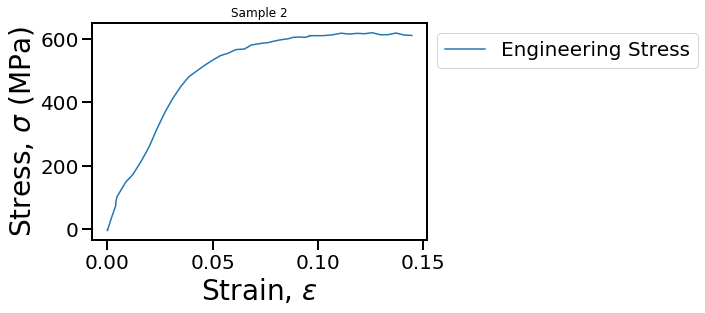

In [9]:
## Load mechanical data from file

##Sample3
'''dir_prefix = r'C:\Users\mbgnwob2\Dropbox (The University of Manchester)\2. Project\Python Script\Single Peak Fitting Script ORIGINAL - Copy'
Eng_stress = np.loadtxt(dir_prefix + '\\Force_Strain_Sample3.txt', usecols=0)
Eng_stress = Eng_stress*10**3/(1.12*3.22)
Eng_strain = np.loadtxt(dir_prefix + '\\Force_Strain_Sample3.txt', usecols=1)
plt.plot(Eng_strain, Eng_stress, label = 'Engineering Stress')
plt.plot(Eng_strain[10], Eng_stress[10], 'bo')
plt.legend(loc=2, bbox_to_anchor=(1, 1))
plt.ylabel('Stress, $\sigma$ (MPa)', fontsize=28)
plt.xlabel('Strain, ${\epsilon}$', fontsize=28)'''


Eng_stress = np.loadtxt(base_dir + '\Stress_strain_Tension_Samp2.txt', usecols=0)
Eng_stress = Eng_stress[:-1]
Eng_strain = np.loadtxt(base_dir + '\Stress_strain_Tension_Samp2.txt', usecols=1)
Eng_strain = Eng_strain[:-1]
plt.plot(Eng_strain, Eng_stress, label = 'Engineering Stress')
plt.legend(loc=2, bbox_to_anchor=(1, 1))
plt.ylabel('Stress, $\sigma$ (MPa)', fontsize=28)
plt.xlabel('Strain, ${\epsilon}$', fontsize=28)
plt.title('Sample 2')

In [10]:
## Load in all intensity files and chack how many exist ##update location required
dicts = glob.glob(pickles_dir + pickle_ftype)
num_dicts=len(dicts)
dics_list = list(dicts)


print('Number of files in dir = ', num_dicts)
dic_names = []
for i in dics_list:
    x = (i.split('\\')[-1])
    dic_names.append(x)
print('Length of names list: ', len(dic_names))
#for i in dic_names:
    #print(i)

Number of files in dir =  108
Length of names list:  108


In [11]:
pp_range_rad = np.arange(0, (2*pi), ((2*pi)/36))
pp_range_deg = pp_range_rad*(180/pi)
pp_range_cake = pp_range_deg/10
cake_nums = []
for i in pp_range_cake:
    cake = str(int(round(i)))
    cake_nums.append(cake)
#print(cake_nums)
#print(pp_range_rad)

## Unpack & sort matrix data

In [12]:
##unpack pickles

list_ZrH_peaks, list_ZrH_peak_centres, list_ZrH_peak_fwhm, list_ZrH_peak_amplitude, list_matrix_peaks, list_matrix_peak_centers, list_matrix_peak_fwhm, list_matrix_peak_amplitude = unpack_pickles(dic_names, pickles_dir)

In [13]:
print(len(list_matrix_peaks))
print(len(list_ZrH_peaks))

print('Number of pickle files = {}'.format(len(list_matrix_peak_centers)),'\nNumber of steps = {}'.format(len(list_matrix_peak_centers[0])))
x = len(list_matrix_peak_centers)*len(list_matrix_peak_centers[0])

138
108
Number of pickle files = 138 
Number of steps = 58


In [14]:
## pickles were unpacked in an unordered list
# use order_peaks)n_cakes to generate lists of the order

matrix_peak_names = ['(01-10)', '(11-20)', '(02-20)', '(01-13)']

m_cakes_list, m_peaks_list, z_cakes_list, z_peaks_list = order_peaks_n_cakes(list_matrix_peaks, list_ZrH_peaks)

#print(len(m_cakes_list), len(m_peaks_list), m_cakes_list,'\n', m_peaks_list, '\n')
#print(len(z_cakes_list), len(z_peaks_list), z_cakes_list, z_peaks_list)

In [15]:
#Convert peak centres to lattice strain

m_strains_list = []

for i in list_matrix_peak_centers:
    L_strain = calc_strain_singlepoint(i)*1e6
    L_strain = list(L_strain)
    m_strains_list.append(L_strain)
    
#print(len(m_strains_list[17]))

In [16]:
##arrange all matrix data by peak (original format = as seperate lists, new format = [peak][cake][step])

m_strains_by_peak, m_cakes_by_peak, m_peaks_by_peak, m_fwhm_by_peak, m_amp_by_peak, m_cntr_by_peak = all_mx_by_peak(m_peaks_list, m_cakes_list, m_strains_list, list_matrix_peak_fwhm, list_matrix_peak_amplitude, list_matrix_peak_centers)

In [17]:
## convert from pervious format to: [peak][step][cake]

m_strains2, m_fwhm2, m_amp2, m_cntr2 = arrange_mx_pk_step(m_strains_by_peak, m_cakes_by_peak, m_peaks_by_peak, m_fwhm_by_peak, m_amp_by_peak, m_cntr_by_peak)

#print(len(m_strains2), len(m_fwhm2), len(m_amp2), len(m_cntr2))
#print(len(m_strains2[0]), len(m_fwhm2[0]), len(m_amp2[0]), len(m_cntr2[0]))
#print(len(m_strains2[1][0]), len(m_fwhm2[1][0]), len(m_amp2[1][0]), len(m_cntr2[1][0]))

IndexError: list index out of range

In [ ]:
##Test plot
##Data looks like this: m_strains2[peak][step][cake-strain]

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

widgets.interact(mx_fwhm_plt_by_steps, step=steps_slide_bar(), pp_range_rad=fixed(pp_range_rad), m_fwhm2=fixed(m_fwhm2), matrix_peak_names=fixed(matrix_peak_names), cake_nums=fixed(cake_nums))

In [ ]:
widgets.interact(mx_amp_plt_by_steps, step=steps_slide_bar(), pp_range_rad=fixed(pp_range_rad), m_amp2=fixed(m_amp2), matrix_peak_names=fixed(matrix_peak_names), cake_nums=fixed(cake_nums))

## Sort Hydride Peaks

In [ ]:
#Convert zrh peak centres to lattice strain
z_strains_list = []

for i in list_ZrH_peak_centres:
    L_strain = calc_strain_singlepoint(i)*1e6
    L_strain = list(L_strain)
    z_strains_list.append(L_strain)

zrh_pk_names = ['111', '220', '311']
        
peak_cake_pos, peak_centres, z_fwhm, z_amp = all_zrh_by_peak(zrh_pk_names, list_ZrH_peaks, list_ZrH_peak_centres, list_ZrH_peak_fwhm, list_ZrH_peak_amplitude)

In [ ]:
z_strains_by_peak, z_cakes_by_peak, z_fwhm_by_peak, z_amp_by_peak, z_cntr_by_peak = arrange_zrh_by_peak(z_peaks_list, z_cakes_list, z_strains_list, list_ZrH_peak_fwhm, list_ZrH_peak_amplitude, list_ZrH_peak_centres)

In [ ]:
##re-arrange zrh data into format: [peak][step][cake-strain]

z_strains2, z_fwhm2, z_amp2, z_cntr2 = arrange_zrh_pk_step(z_strains_by_peak, z_fwhm_by_peak, z_amp_by_peak, z_cntr_by_peak)

In [ ]:
##Test plot
##Data looks like this: m_strains2[peak][step][cake-strain]

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

widgets.interact(zrh_fwhm_plt_by_steps, step=steps_slide_bar(), pp_range_rad=fixed(pp_range_rad), z_fwhm2=fixed(z_fwhm2), zrh_pk_names=fixed(zrh_pk_names), cake_nums=fixed(cake_nums))

In [ ]:
widgets.interact(zrh_amp_plt_by_steps, step=steps_slide_bar(), pp_range_rad=fixed(pp_range_rad), z_amp2=fixed(z_amp2), zrh_pk_names=fixed(zrh_pk_names), cake_nums=fixed(cake_nums))

## Investigate difference in stress/ strain etc accross opposites


In [ ]:
###strains_list2[peak][step][cake-strain]

diffs = [[],[],[]]

for i in range(36): #'111''56' = 36
    cake = i
    opp = i+36/2
    if opp >= 36:
        opp = -18+i
    opp = int(opp)
    
    for j in range(3):
        if z_strains2[j][56][cake] == 0 or z_strains2[j][56][opp] == 0: 
            diff = 0
            diffs[j].append(diff)

        else:
            diff = z_strains2[j][56][cake] - z_strains2[j][56][opp]
            diffs[j].append(diff)
        
for k, peak in enumerate(pk_names):
    print(peak)
    for j in range(36):
        opp = j+int(36/2)
        if opp >= 36:
            opp = -18+j
        #print(j, '\t', int(z_strains2[k][56][j]), '\t', opp, '\t', int(z_strains2[k][56][opp]),'\t', diffs[k][j])
    #print('\n')


In [ ]:
###strains_list2[peak][step][cake-strain]
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


fig, ax = plt.subplots(figsize=(10, 10))
ax = plt.subplot(111, projection='polar')
ax.plot(pp_range_rad, medfilt(diffs[0], 3), label = '(111)')
ax.plot(pp_range_rad, medfilt(diffs[1], 3), label = '(220)')
#ax.plot(pp_range_rad, diffs[2], label = '(311)')
ax.legend(loc = 0, bbox_to_anchor = (1.1, 1.1))
ax.set_rlabel_position(0)  # Move radial labels away from plotted line
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N', offset=0)
ax.set_xticks(np.pi/180. * np.linspace(0, 360, 36, endpoint=False))
ax.set_rorigin(-2000)
#ax.set_rmax(30000)
#ax.set_rmin(-5000)
ax.set_xticklabels(cake_nums)
title = 'S2_Difference in opposing hydride strain_S56 \n\n *Difference, in microstrain on radial axis \n *Cake position on theta axis'
ax.set_title(title, va='bottom')

gridlines = ax.yaxis.get_gridlines()
gridlines[3].set_color("grey")
gridlines[3].set_linewidth(2.5)

plt.show()

plot_name= str(out_dir+'\\'+'difference in opposing strains_hydride_111_220')
#print(plot_name)
fig.savefig(plot_name, bbox_inches='tight')

In [ ]:
###strains_list2[peak][step][cake-strain]

pcnt_diffs = [[],[],[]] # strain c0 - strain c18/strain c18

for i in range(36): #'111''56' = 36
    cake = i
    opp = i+36/2
    if opp >= 36:
        opp = -18+i
    opp = int(opp)
    
    for j in range(3):
        if z_strains2[j][56][cake] == 0 or z_strains2[j][56][opp] == 0: 
            diff = 0
            pcnt_diffs[j].append(diff)

        else:
            diff = 100*(z_strains2[j][56][cake] - z_strains2[j][56][opp])/z_strains2[j][56][opp]
            pcnt_diffs[j].append(diff)
        
for k, peak in enumerate(pk_names):
    print(peak)
    for j in range(36):
        opp = j+int(36/2)
        if opp >= 36:
            opp = -18+j
        #print(j, '\t', int(z_strains2[k][56][j]), '\t', opp, '\t', int(z_strains2[k][56][opp]),'\t', pcnt_diffs[k][j])
    #print('\n')


In [ ]:
###strains_list2[peak][step][cake-strain]
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


fig, ax = plt.subplots(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')
ax.plot(pp_range_rad, medfilt(pcnt_diffs[0], 3), label = '(111)')
ax.plot(pp_range_rad, medfilt(pcnt_diffs[1], 3), label = '(220)')
#ax.plot(pp_range_rad, pcnt_diffs[2], label = '(311)')
ax.legend(loc = 0, bbox_to_anchor = (1.1, 1.1))
ax.set_rlabel_position(0)  # Move radial labels away from plotted line
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N', offset=0)
ax.set_xticks(np.pi/180. * np.linspace(0, 360, 36, endpoint=False))
ax.set_rorigin(-100)
#ax.set_rmax(30000)
#ax.set_rmin(-5000)
ax.set_xticklabels(cake_nums)

gridlines = ax.yaxis.get_gridlines()
gridlines[4].set_color("grey")
gridlines[4].set_linewidth(2.5)

plt.show()

plot_name= str(out_dir+'\\'+'difference')
#print(plot_name)

fig.savefig(plot_name, bbox_inches='tight')

## Williamson Hall Plots

In [ ]:
##Let's set up some constants 
C_zrh_h00 = 3.2
C_mx_h00 = 3.2
q_zrh = 2.5
q_mx = 0.5
wavelength = 0.0141565

In [ ]:
## And now calculate some parameters

Hsqd_zrh111 = H_sqd(1,1,1)
Hsqd_zrh200 = H_sqd(2,0,0)
Hsqd_zrh220 = H_sqd(2,2,0)
Hsqd_zrh311 = H_sqd(3,1,1)
Hsqd_zrh = [Hsqd_zrh111, Hsqd_zrh220, Hsqd_zrh311]

Hsqd_mx100 = H_sqd(1,0,0)
Hsqd_mx110 = H_sqd(1,1,0)
Hsqd_mx200 = H_sqd(2,0,0)
Hsqd_mx103 = H_sqd(1,0,3)
Hsqd_mx = [Hsqd_mx100, Hsqd_mx110, Hsqd_mx200, Hsqd_mx103]

C_zrh111 = Contrast_Factor(C_zrh_h00, q_zrh, Hsqd_zrh111)
C_zrh200 = Contrast_Factor(C_zrh_h00, q_zrh, Hsqd_zrh200)
C_zrh220 = Contrast_Factor(C_zrh_h00, q_zrh, Hsqd_zrh220)
C_zrh311 = Contrast_Factor(C_zrh_h00, q_zrh, Hsqd_zrh311)
C_zrh = [C_zrh111, C_zrh220, C_zrh311]

C_mx100 = Contrast_Factor(C_mx_h00, q_mx, Hsqd_mx100)
C_mx110 = Contrast_Factor(C_mx_h00, q_mx, Hsqd_mx110)
C_mx200 = Contrast_Factor(C_mx_h00, q_mx, Hsqd_mx200)
C_mx103 = Contrast_Factor(C_mx_h00, q_mx, Hsqd_mx103)
C_mx = [C_mx100, C_mx110, C_mx200, C_mx103]

In [ ]:
K_zrh, dK_zrh, K_mx, dK_mx = WH_parameters_K_dK(z_cntr2, z_fwhm2, m_cntr2, m_fwhm2, wavelength)

In [ ]:
K_rootC_zrh, K_rootC_mx = K_root_C(K_zrh, C_zrh, K_mx, C_mx)

In [ ]:
##W-H Plot for all 

cake = 0
step = slice(None, None,1)

W_H_Plots(cake, step, zrh_pk_names, K_rootC_zrh, dK_zrh, matrix_peak_names, K_rootC_mx,dK_mx)

## Looking at line broardening: 


In [ ]:
widgets.interact(plt_fwhm_vs_strain, cakes = cake_menu(), z_dK=fixed(dK_zrh), mx_dK=fixed(dK_mx), Eng_strain=fixed(Eng_strain[:-1]), 
                 z_strains_by_peak=fixed(z_strains_by_peak), m_strains_by_peak=fixed(m_strains_by_peak))

In [ ]:
widgets.interact(plt_fwhm_vs_step, cakes=cake_menu(), z_dK=fixed(dK_zrh), mx_dK=fixed(dK_mx), Eng_strain=fixed(Eng_strain[:-1]), 
                 z_strains_by_peak=fixed(z_strains_by_peak), m_strains_by_peak=fixed(m_strains_by_peak))